In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os, glob, shutil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2
import math

Assign Constants

In [ ]:
#Input paths
data_path = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/'
training_img_path = os.path.join(data_path, 'data_splits_raw/training/img_raw/raw/')
training_couinaud_path = os.path.join(data_path, 'data_splits_raw/training/couinaud_raw/raw/')

testing_img_path = os.path.join(data_path, 'data_splits_raw/testing/img_raw/raw/')
testing_couinaud_path = os.path.join(data_path, 'data_splits_raw/testing/couinaud_raw/raw/')

validate_img_path = os.path.join(data_path, 'data_splits_raw/validate/img_raw/raw/')
validate_couinaud_path = os.path.join(data_path, 'data_splits_raw/validate/couinaud_raw/raw/')\

#Output paths (Preprocessed data)
# NOTE : Ensure these foldters exist 
training_img_out_path = os.path.join(data_path, 'data_splits_preprocessed/training/img:-1000:2000/img/')
training_couinaud_out_path = os.path.join(data_path, 'data_splits_preprocessed/training/couinaud/img/')


testing_img_out_path = os.path.join(data_path, 'data_splits_preprocessed/testing/img:-1000:2000/img/')
testing_couinaud_out_path = os.path.join(data_path, 'data_splits_preprocessed/testing/couinaud/img/')

validate_img_out_path = os.path.join(data_path,'data_splits_preprocessed/validate/img:-1000:2000/img/')
validate_couinaud_out_path = os.path.join(data_path,'data_splits_preprocessed/validate/couinaud/img/')

# Image normalization
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 1000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# Couinaud segmentation colors
viridis = plt.cm.get_cmap('jet_r')
newcolors = viridis(np.linspace(0, 1, 20))
clear = np.array([256/256, 256/256, 256/256, 0])
red = np.array([256/256, 0/256, 0/256, 0.3])
orange = np.array([256/256, 165/256, 0/256, 1])
yellow = np.array([256/256, 256/256, 0/256, 1])
green = np.array([0/256, 256/256, 0/256, 1])
turquoise = np.array([0/256, 256/256, 209/256, 1])
blue = np.array([0/256, 0/256, 256/256, 1])
purple = np.array([128/256, 0/256, 128/256, 1])

newcolors[0, :] = clear
newcolors[1, :] = red
newcolors[2, :] = orange
newcolors[3, :] = yellow
newcolors[4, :] = green
newcolors[5, :] = turquoise
newcolors[6, :] = blue
newcolors[7, :] = purple
newcmp = ListedColormap(newcolors)

Visualize the data

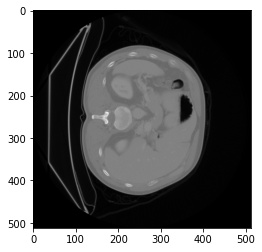

In [ ]:
# Load and show image slice from the raw data 
img_path = os.path.join(training_img_path, 'hepaticvessel_001.nii.gz')
img = nib.load(img_path).get_fdata()
img_slice = img[:,:,math.floor(img.shape[2] / 2)]
plt.imshow(img_slice, cmap = 'gray')
plt.show()

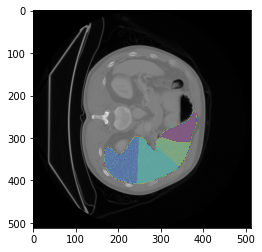

In [ ]:
# Load and show couinaud slice from raw data with color mask
couinaud_path = os.path.join(training_couinaud_path, 'hepaticvessel_001.nii.gz')
couinaud = nib.load(couinaud_path).get_fdata()
couinaud_slice = couinaud[:,:,math.floor(img.shape[2] / 2)]
plt.imshow(img_slice, cmap = 'gray')
plt.imshow(couinaud_slice, cmap = newcmp, rasterized=True, vmin=0, vmax=8, alpha = 0.3)
plt.show()

[0. 1. 3. 4. 5. 6.]


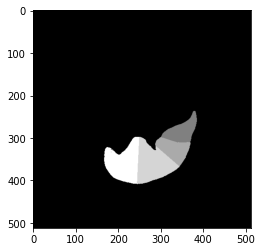

In [ ]:
plt.imshow(couinaud_slice, cmap = 'gray')
print(np.unique(couinaud_slice))

Preprocessing Functions

In [ ]:
# Normalize image
def normalizeImageIntensityRange(img): 
  img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
  img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
  return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

In [ ]:
# Read image or mask volume
def readImageVolume(imgPath, normalize = False):
  img = nib.load(imgPath).get_fdata()
  if normalize:
    return normalizeImageIntensityRange(img)
  else:
    return img

In [ ]:
# Save an individual slice
def saveSlice(img, fname, path, isCouinaudMask = False):
  if (isCouinaudMask):   
    img = np.uint8(img)
    fout = os.path.join(path, f'{fname}.tif')
    cv2.imwrite(fout, img)
    print('  ---> as :', fout)
  else: 
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print('  ---> as :', fout)
  

In [ ]:
# Extract all slices of a CT Scan 
def extractandSaveAllSlices(vol, fname, path, isCouinaudMask):
  num_slices = vol.shape[2]

  for i in range(num_slices):
    name = fname + 'slice:' + str(i)
    img = vol[:,:,i]
    saveSlice(img, name, path, isCouinaudMask=isCouinaudMask)

Preprocess Data

In [ ]:
# Read and process training image volumes
for index, filename in enumerate(sorted(glob.iglob(training_img_path + '*.nii.gz'))):
  img = readImageVolume(filename, True)
  nii_file_name = filename.split('/')[-1].split('.')[0]
  extractandSaveAllSlices(img, nii_file_name, training_img_out_path, isCouinaudMask=False)
  print("Saved slice", filename)
 

In [ ]:
# Read and process training couinaud volumes
for index, filename in enumerate(sorted(glob.iglob(training_couinaud_path + '*.nii.gz'))):
  img = readImageVolume(filename, False)
  nii_file_name = filename.split('/')[-1].split('.')[0]
  extractandSaveAllSlices(img, nii_file_name, training_couinaud_out_path, isCouinaudMask=True)
  print("Saved slice", filename)

In [ ]:
# Read and process testing image volumes
for index, filename in enumerate(sorted(glob.iglob(testing_img_path + '*.nii.gz'))):
  img = readImageVolume(filename, True)
  nii_file_name = filename.split('/')[-1].split('.')[0]
  extractandSaveAllSlices(img, nii_file_name, testing_img_out_path, isCouinaudMask=False)
  print("Saved slice", filename)

In [ ]:
# Read and process testing couinaud volumes
for index, filename in enumerate(sorted(glob.iglob(testing_couinaud_path + '*.nii.gz'))):
  img = readImageVolume(filename, False)
  nii_file_name = filename.split('/')[-1].split('.')[0]
  extractandSaveAllSlices(img, nii_file_name, testing_couinaud_out_path, isCouinaudMask=True)
  print("Saved slice", filename)

In [ ]:
# Read and process validate image volumes
for index, filename in enumerate(sorted(glob.iglob(validate_img_path + '*.nii.gz'))):
  img = readImageVolume(filename, True)
  nii_file_name = filename.split('/')[-1].split('.')[0]
  extractandSaveAllSlices(img, nii_file_name, validate_img_out_path, isCouinaudMask=False)
  print("Saved slice", filename)

In [ ]:
# Read and process validate couinaud volumes
for index, filename in enumerate(sorted(glob.iglob(validate_couinaud_path + '*.nii.gz'))):
  img = readImageVolume(filename, False)
  nii_file_name = filename.split('/')[-1].split('.')[0]
  extractandSaveAllSlices(img, nii_file_name, validate_couinaud_out_path, isCouinaudMask=True)
  print("Saved slice", filename)